# HW5: designing a microscope using machine learning

For the final homework assignment, we will design a microscope using machine learning! In order to do this, we will combine elements of HW3 (CNNs) and HW4 (microscope simulator) into a single end-to-end architecture. In particular, we will convert the white blood cell images into phase/amplitude objects, and then process them through a microscope simulator as we did in HW4, add noise, and then feed the resulting images into a CNN for classification. In addition to optimizing the CNN parameters, we will also be simultaneously optimizing the intensity of input illumination incident on the phase/amplitude objects to try to improve classification performance.

Below, we will walk you through the steps of implementing this joint architecture, leaving some portions blank for you to implement. We will instruct you to use specific values that we have tested and are known to give reasonable results.

Some code adapted from https://www.tensorflow.org/tutorials/quickstart/advanced


## 1. import stuff and load the dataset
As always, we split the dataset into training and testing. You can just run this code, you don't need to understand what's going on

In [1]:
# if this breaks please contact the TAs
!wget -O data.zip https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded
!unzip /content/data.zip
!unzip /content/PBC_dataset_normal_DIB > /dev/null

Streaming output truncated to the last 5000 lines.
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_935950.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_890863.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_519370.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_215077.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_388154.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_968896.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_34345.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_349907.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_245683.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_785122.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_615525.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_714613.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_904757.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_38351.jpg  
  inflating: PBC_dataset_no

In [2]:
from tensorflow.python.ops.gen_math_ops import sub
# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

def load_and_crop(image_path, crop_size, normalized=False):
    image = Image.open(image_path) .resize([256,256])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# code to load all the data, assuming dataset is at PBC_dataset_normal_DIB relative path
cell_types = ['lymphocyte', 'monocyte', 'neutrophil']
cell_inds = np.arange(0, len(cell_types))
x_data = []
y_data = []
for cell_ind in cell_inds:
    all_images = glob.glob(os.path.join('PBC_dataset_normal_DIB', cell_types[cell_ind], '*.jpg'))
    x_data += [load_and_crop(image_path, 128) for image_path in all_images]
    y_data += [cell_ind]*len(all_images)

(4770, 128, 128) (4770, 3)
(1193, 128, 128) (1193, 3)


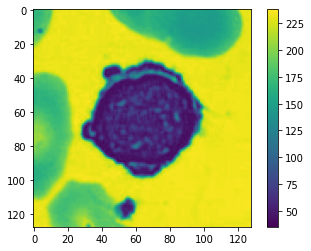

In [3]:
# generating train/val indices
folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.seed(0)
np.random.shuffle(train_indices)

x_data = np.array(x_data)
y_data = np.array(y_data)

x_train = x_data[train_indices]
y_train = np.eye(len(cell_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(cell_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:])
plt.colorbar()

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_test = x_val
y_test = y_val
x_train, x_test = x_train / 255.0, x_test / 255.0  # customary normalization to [0, 1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4770, 128, 128) (4770, 3)
(1193, 128, 128) (1193, 3)


## 2. convert the images into microscope samples
Like HW4, we'll just use an image that represents absorption, and then make an approximation to estimate its optical thickness. We will assume that the sample's optical thickness is directly proportional to how much light is absorbed by the sample, allowing you to use the image itself to define both the absorption and phase delay components of the simulated microscope samples. Please convert the images into amplitude/phase objects, assuming that the maximum absorption for a given sample is 1, and the maximum phase delay for each sample is 20 wavelengths. We'll assume the wavelength of the light in this microscope is 500 nm, or 0.5 µm.

In [5]:
wavelength = .5e-3 # units are mm; assuming green light
delta_x = 0.5*wavelength # let's sample at nyquist rate
num_samples = 128

# in real world, microscope samples are 3D and have thickness, which introduce a phase shift to the optical field
# For simplicity, let's further assume the sample thickness and amplitude are inversely correlated, which means the thicker the sample is,
# the more light it absorb.
def convert_images(sample_amplitude):
    sample_phase = 1 - sample_amplitude
    optical_thickness = 20 * wavelength
    return sample_amplitude * np.exp(1j * sample_phase*optical_thickness/wavelength)

x_train = convert_images(x_train)
x_test = convert_images(x_test)

Next, let's generate a new dataset that contains differently illuminated sample images. We will model a plane wave hitting this thin sample like we did for HW4. We will start by modeling 9 different illumination angles for each simulated sample of interest, provided by a 3x3 array of LEDs positioned beneath the sample of interest. Let's assume the center LED is directly beneath the specimen, and that the neighboring LEDs are offset by a 10 degree angle from the center. This will allow us to see how the images change with different illumination angles. Please recall that illumination from a particular angle shifts the sample spectrum across the microscope aperture, causing different components of the shifted spectrum to pass through and onto the detector for different illumination angles. The general process is exactly same as what was considered in HW4. Here, we will model the microscope aperture as a circle, whose effect within this simulation model is to allow only the center pixels of the sample spectrum to pass through the lens and onto the image sensor. Please model and show what the 9 uniquely illuminated images appear like.  

In [6]:
def crop_center(sample, cropx, cropy):
    y,x = sample.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return sample[starty:starty+cropy,startx:startx+cropx]

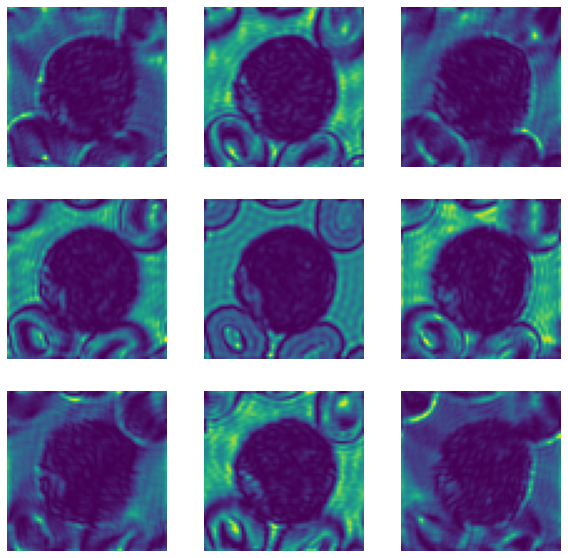

In [7]:
# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples = 128
delta_fx = f_range/num_samples


# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates.
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# define angles
plane_wave_angle_xy = np.array([[0,0], [10,0], [10,10], [0,10], [-10,10], [-10,0], [-10,-10], [0,-10], [10,-10]]) * np.pi/180

# generate illumination dataset
illumination_data = np.zeros((64,64,9))
sample = x_test[0]
iff_list=[]
for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
    # Define plane waves
    plane_wave_angle_x = plane_wave_angle[0]
    plane_wave_angle_y = plane_wave_angle[1]
    illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

    # Define field emerging from sample
    emerging_field = np.multiply(illumination_plane_wave, sample)
    
    # Take 2D fourier transform of sample
    fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

    # Create filtered sample spectrum with center crop (64 x 64)
    # trans: only within desired radius is 1
    # so we can crop the outer part
    filtered_sample = np.multiply(fourier_field, trans)
    filtered_sample = crop_center(filtered_sample,64,64)


    #  Propagate filtered sample spectrum to image plane
    # x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
    # y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
    # xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

    # Propagate filtered sample spectrum to image plane
    inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))
    detected_field = np.square(np.abs(inverse_fourier_field))
    illumination_data[:,:,i] = detected_field
    
order = [5,6,9,8,7,4,1,2,3]
plt.figure(figsize=(10,10))
for i in range(len(plane_wave_angle_xy)):
    plt.subplot(3, 3, order[i])
    plt.imshow(illumination_data[...,i])
    plt.axis('off')

Please write a function that returns the 9 illuminated images for each sample as output, given each sample as input. You would mostly reuse the code above.

In [8]:
x_train_illumination = np.zeros((4770,64,64,9))
x_test_illumination = np.zeros((1193,64,64,9))

def return_illumination_data(sample):

    illumination_data = np.zeros((64, 64, 9))
    
    for i, plane_wave_angle in enumerate(plane_wave_angle_xy):
        # Define plane waves
        illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle[0]) * xx + np.sin(plane_wave_angle[1]) * yy))

        # Define field emerging from sample
        emerging_field = np.multiply(illumination_plane_wave, sample)
    
        # Take 2D fourier transform of sample
        fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

        # Create filtered sample spectrum with center crop (64 x 64)
        #trans64x64 = np.zeros((num_samples, num_samples))
        #trans64x64[int(num_samples/2)+32:int(num_samples/2)-32,int(num_samples/2)+32:int(num_samples/2)-32] = 1
        filtered_sample = np.multiply(fourier_field, trans)
        filtered_sample = crop_center(filtered_sample,64,64)

        # Propagate filtered sample spectrum to image plane
        inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

        # save the intensity of inverse_fourier_field
        detected_field = np.square(np.abs(inverse_fourier_field))
        illumination_data[:,:,i] = detected_field

    return illumination_data

for i in range(len(x_train_illumination)):
    x_train_illumination[i] = return_illumination_data(x_train[i])
for i in range(len(x_test_illumination)):
    x_test_illumination[i] = return_illumination_data(x_test[i])

In [9]:
print(x_train_illumination.shape, x_test_illumination.shape)

(4770, 64, 64, 9) (1193, 64, 64, 9)


The function was executed correctly as you can see the shapes of both the x training and x testing dimensions are as expected. Several thousand images that are 64x64 pixels in size and have 9 channels each for 9 different "illuminations"

## 3. Define variables for physical layer

Next, we will create a trainable matrix (use tf.keras.layers.Conv2D) for the intensity of input illumination. Using this layer, we will compute a weighted sum of images that were filtered by the lens transfer function. Here we will have 9 float values that interact with each sample. Please implement code for the illumination layer (hint: 1*1 convolution) and think carefully about its arguments. In practice, this illumination pattern can be obtained by an led array.

In [10]:
import tensorflow as tf

In [11]:
class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination, self).__init__()
        self.is_train=is_train

    def build(self, input_shape):
        # initialize illumination weight with 0 mean 0.05 std
        # because its a 1x1 convolution, the filters, kernel size, and stide are all 1.
        weight_init = tf.random_normal_initializer(mean=0, stddev=0.05)
        self.weight = tf.Variable(initial_value=weight_init(shape=(1, 1, input_shape[-1],1)), trainable=self.is_train)
    
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, self.weight, [1, 1, 1, 1], padding='SAME')
        return tf.nn.relu(x)

## 4. Process the simulated image through a CNN
Use your favorite CNN architecture to classify the resulting captured data, with the simultaneous goal of determining an optimal 3x3 LED pattern. You can copy a network architecture from a model summary below for the classification component (e.g., a 5-layer CNN will be just fine). The key idea is to create and deploy optimization of a physical layer, which computes a weighted sum of the 9 simulated images for each sample, as discussed in class.

In [22]:
image_size = (64, 64, 9)
custom_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination(is_train=False), #is_train is false here as we are not training the illumination layer yet in question 1a
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_2 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 6)         906       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 6)        0         
 2D)                                                             
                                                      

## Questions

Ok, now you are ready to run a machine learning model with a physical layer! You did it! To complete the remainder of the homework, please follow the instructions for each question below, and then respond accordingly with the requested information. If it is helpful, please also copy and paste any major code changes into the question response, to help us assess what you did. Note that this is a pretty open-ended analysis, and everyone may achieve different results depending on the selected parameters.

1. Using the default hyperparameters based on the instructions and code that we provided, and please run the training under the following conditions:

    a. Allow for the optimization of CNN only (no illumination!). Note that this is a control experiment, because only the CNN is trained, and not the physical layers.
    
    b. Allow for the optimization of the the illumination that illuminates the sample.

    c. Repeat the b. but add noise term which simulates sensor noise before feedind the resulting images into a CNN for classification. 
  
    d. In reality, the brightness of an LED cannot be negative. A simple trick exists to account for this is, by capturing two images (can you think of what that might be?). In any case, it is helpful to also try to constrain the optimized weights to be non-negative. Please try to add this non-negative constraint in from c. (still with the tf.keras.layers.Conv2D - you need to edit the Illumination class) and see if 1) you are able to successfully optimize weights that are non-negative, and 2) how this impacts performance.
    
    For these 4 conditions, report the final test classification accuracies. Also, print the illumination weight and an output image just after the illumination layer for before and after the training. Provide a brief analysis of the results (hint: if you don't see a difference between the above conditions, something probably went wrong!).

## 1 (a)

In [23]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

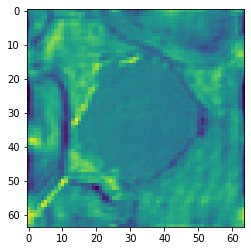

In [24]:
# plot output image just after the illumination layer before training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [25]:
# print illumination weight before training
custom_model.layers[0].get_weights()

[array([[[[-0.04494106],
          [ 0.00552767],
          [-0.04438452],
          [ 0.02719382],
          [ 0.00842421],
          [-0.00253891],
          [ 0.07086229],
          [ 0.06403264],
          [-0.05231781]]]], dtype=float32)]

In [26]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 3s 14ms/step - loss: 0.4802 - accuracy: 0.8078 - val_loss: 0.3191 - val_accuracy: 0.8860
Epoch 2/10
150/150 [==============================] - 2s 10ms/step - loss: 0.2904 - accuracy: 0.8990 - val_loss: 0.2491 - val_accuracy: 0.9170
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.2439 - accuracy: 0.9149 - val_loss: 0.2222 - val_accuracy: 0.9254
Epoch 4/10
150/150 [==============================] - 2s 11ms/step - loss: 0.2170 - accuracy: 0.9237 - val_loss: 0.2081 - val_accuracy: 0.9229
Epoch 5/10
150/150 [==============================] - 2s 11ms/step - loss: 0.2026 - accuracy: 0.9294 - val_loss: 0.2043 - val_accuracy: 0.9170
Epoch 6/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1862 - accuracy: 0.9344 - val_loss: 0.1889 - val_accuracy: 0.9304
Epoch 7/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1721 - accuracy: 0.9392 - val_loss: 0.2394 - val_accuracy: 0.9111

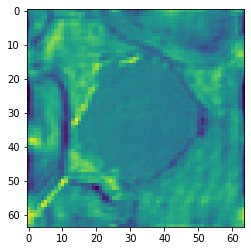

In [27]:
# plot output image just after the illumination layer after training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [28]:
# print illumination weight after training
custom_model.layers[0].get_weights()

[array([[[[-0.04494106],
          [ 0.00552767],
          [-0.04438452],
          [ 0.02719382],
          [ 0.00842421],
          [-0.00253891],
          [ 0.07086229],
          [ 0.06403264],
          [-0.05231781]]]], dtype=float32)]

## 1 (b)

In [29]:
image_size = (64, 64, 9)
custom_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination(is_train=True), #is_train is true as we are optimizing illumination!
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_3 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 6)         906       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 6)        0         
 2D)                                                             
                                                      

In [30]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

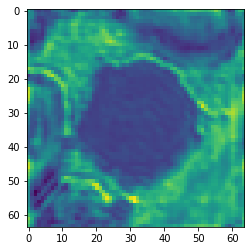

In [31]:
# plot output image just after the illumination layer before training
# plot output image just after the illumination layer before training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [32]:
# print illumination weight before training
custom_model.layers[0].get_weights()

[array([[[[-0.07720212],
          [ 0.03095138],
          [-0.01308395],
          [ 0.00878129],
          [-0.01389926],
          [ 0.02603965],
          [-0.00245164],
          [ 0.09794267],
          [ 0.09670622]]]], dtype=float32)]

In [33]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 3s 13ms/step - loss: 0.4629 - accuracy: 0.7964 - val_loss: 0.1942 - val_accuracy: 0.9346
Epoch 2/10
150/150 [==============================] - 2s 12ms/step - loss: 0.1967 - accuracy: 0.9369 - val_loss: 0.1599 - val_accuracy: 0.9447
Epoch 3/10
150/150 [==============================] - 2s 12ms/step - loss: 0.1679 - accuracy: 0.9453 - val_loss: 0.1572 - val_accuracy: 0.9455
Epoch 4/10
150/150 [==============================] - 2s 12ms/step - loss: 0.1515 - accuracy: 0.9472 - val_loss: 0.1520 - val_accuracy: 0.9547
Epoch 5/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1306 - accuracy: 0.9566 - val_loss: 0.1319 - val_accuracy: 0.9589
Epoch 6/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1128 - accuracy: 0.9612 - val_loss: 0.1409 - val_accuracy: 0.9539
Epoch 7/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1090 - accuracy: 0.9637 - val_loss: 0.1290 - val_accuracy: 0.9614

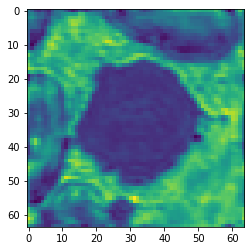

In [34]:
# plot output image just after the illumination layer after training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [35]:
# print illumination weight after training
custom_model.layers[0].get_weights()

[array([[[[-0.0069834 ],
          [ 0.07221077],
          [-0.05444426],
          [-0.06385417],
          [-0.06162786],
          [ 0.05005021],
          [ 0.04261259],
          [ 0.22313443],
          [ 0.09899297]]]], dtype=float32)]

## 1 (c)
hint: tf.keras.layers.GaussianNoise(0.05)

In [37]:
image_size = (64, 64, 9)
custom_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination(is_train=True), #is_train is true as we are optimizing illumination!
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_5 (Illuminatio  (None, 64, 64, 1)        9         
 n)                                                              
                                                                 
 gaussian_noise (GaussianNoi  (None, 64, 64, 1)        0         
 se)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 6)         906       
                                                      

In [38]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

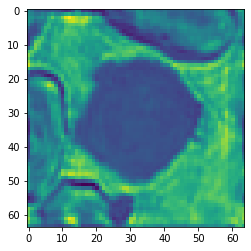

In [40]:
# plot output image just after the illumination layer before training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [41]:
# print illumination weight before training
custom_model.layers[0].get_weights()

[array([[[[ 0.0409307 ],
          [ 0.09317296],
          [ 0.02080122],
          [-0.03761729],
          [-0.01250635],
          [ 0.01359549],
          [-0.01423101],
          [ 0.01524796],
          [-0.03587615]]]], dtype=float32)]

In [42]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 3s 16ms/step - loss: 0.4555 - accuracy: 0.7975 - val_loss: 0.2322 - val_accuracy: 0.9162
Epoch 2/10
150/150 [==============================] - 2s 13ms/step - loss: 0.2108 - accuracy: 0.9224 - val_loss: 0.2300 - val_accuracy: 0.9086
Epoch 3/10
150/150 [==============================] - 2s 12ms/step - loss: 0.1775 - accuracy: 0.9382 - val_loss: 0.1480 - val_accuracy: 0.9489
Epoch 4/10
150/150 [==============================] - 2s 13ms/step - loss: 0.1495 - accuracy: 0.9484 - val_loss: 0.2055 - val_accuracy: 0.9313
Epoch 5/10
150/150 [==============================] - 2s 12ms/step - loss: 0.1254 - accuracy: 0.9585 - val_loss: 0.1770 - val_accuracy: 0.9405
Epoch 6/10
150/150 [==============================] - 2s 13ms/step - loss: 0.1264 - accuracy: 0.9543 - val_loss: 0.1330 - val_accuracy: 0.9573
Epoch 7/10
150/150 [==============================] - 2s 12ms/step - loss: 0.0981 - accuracy: 0.9650 - val_loss: 0.1271 - val_accuracy: 0.9598

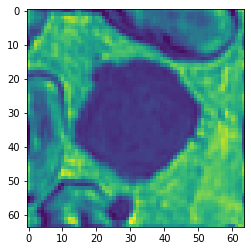

In [44]:
# plot output image just after the illumination layer after training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [45]:
# print illumination weight after training
custom_model.layers[0].get_weights()

[array([[[[ 0.10096603],
          [ 0.19946396],
          [ 0.09475011],
          [-0.02930427],
          [-0.07441347],
          [-0.04288195],
          [-0.06222949],
          [ 0.08768194],
          [ 0.00451175]]]], dtype=float32)]

## 1 (d)

In [264]:
# class NonNegative(tf.keras.constraints.Constraint):
#     def __call__(self, w):
#         return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)

# class Illumination(tf.keras.layers.Layer):
#     def __init__(self, is_train=False):
#         super(Illumination, self).__init__()
#         self.is_train=is_train

#     def build(self, input_shape):
#         # initialize illumination weight with 0 mean 0.05 std
#         # because its a 1x1 convolution, the filters, kernel size, and stide are all 1.
#         weight_init = tf.random_normal_initializer(mean=0, stddev=0.05)
#         self.weight = tf.Variable(initial_value=weight_init(shape=(1, 1, input_shape[-1],1)), 
#                                   trainable=self.is_train, constraint=NonNegative())
#         self.weight=tf.Variable(NonNegative()(self.weight))
    
#     def call(self, inputs):
#         x = tf.nn.conv2d(inputs, self.weight, [1, 1, 1, 1], padding='SAME')
#         return tf.nn.relu(x)

In [280]:
class NonNegative(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)

class Illumination(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Illumination, self).__init__()
        self.is_train=is_train

    def build(self, input_shape):
        self.filt=1
        self.size=(1,1)
        self.stride=1
        self.pad="same"
        self.bias=False
        self.initializer=tf.random_normal_initializer(mean=0, stddev=0.05)
        self.conv2d=tf.keras.layers.Conv2D(filters=self.filt, kernel_size=self.size, strides=self.stride, padding=self.pad, 
                                           use_bias=self.bias, kernel_initializer=self.initializer, kernel_constraint=NonNegative())
    
    def call(self, inputs):
        return self.conv2d(inputs)

In [281]:
image_size = (64, 64, 9)
custom_model = tf.keras.models.Sequential([tf.keras.layers.Input(image_size),
    Illumination(is_train=True), #is_train is true as we are optimizing illumination!
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='relu'), # conv
    tf.keras.layers.MaxPool2D(), # max pooling
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')])

custom_model.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 illumination_70 (Illuminati  (None, 64, 64, 1)        9         
 on)                                                             
                                                                 
 gaussian_noise_65 (Gaussian  (None, 64, 64, 1)        0         
 Noise)                                                          
                                                                 
 conv2d_138 (Conv2D)         (None, 64, 64, 6)         156       
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 32, 32, 6)        0         
 ng2D)                                                           
                                                                 
 conv2d_139 (Conv2D)         (None, 32, 32, 6)         906       
                                                     

In [282]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

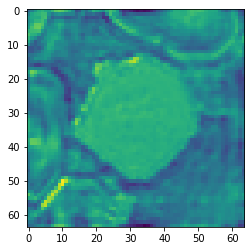

In [283]:
# plot output image just after the illumination layer before training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [284]:
# print illumination weight before training
custom_model.layers[0].get_weights()

[array([[[[-0.07932513],
          [-0.01853703],
          [-0.05775789],
          [ 0.02408706],
          [-0.10126153],
          [-0.01280085],
          [ 0.0846784 ],
          [ 0.04777312],
          [ 0.01301593]]]], dtype=float32)]

In [285]:
# train model
history = custom_model.fit(x_train_illumination, y_train, epochs=10, validation_data=(x_test_illumination, y_test))

Epoch 1/10
150/150 [==============================] - 3s 14ms/step - loss: 0.4357 - accuracy: 0.8285 - val_loss: 0.2516 - val_accuracy: 0.9229
Epoch 2/10
150/150 [==============================] - 2s 12ms/step - loss: 0.2441 - accuracy: 0.9180 - val_loss: 0.2149 - val_accuracy: 0.9254
Epoch 3/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1968 - accuracy: 0.9327 - val_loss: 0.1945 - val_accuracy: 0.9304
Epoch 4/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1609 - accuracy: 0.9463 - val_loss: 0.2006 - val_accuracy: 0.9237
Epoch 5/10
150/150 [==============================] - 2s 12ms/step - loss: 0.1393 - accuracy: 0.9509 - val_loss: 0.1603 - val_accuracy: 0.9497
Epoch 6/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1125 - accuracy: 0.9623 - val_loss: 0.1619 - val_accuracy: 0.9480
Epoch 7/10
150/150 [==============================] - 2s 11ms/step - loss: 0.1012 - accuracy: 0.9648 - val_loss: 0.1643 - val_accuracy: 0.9464

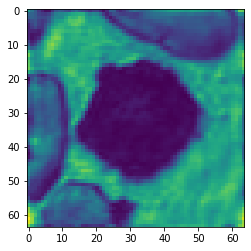

In [286]:
# plot output image just after the illumination layer after training
predictions = np.matmul(x_train_illumination[0,:,:,:], np.array(custom_model.layers[0].get_weights())[0,0,0,:,0])
plt.imshow(predictions)

In [287]:
# print illumination weight after training
custom_model.layers[0].get_weights()

[array([[[[ 3.5345364e-02],
          [ 6.6159817e-04],
          [-0.0000000e+00],
          [ 3.6667200e-04],
          [ 1.4138641e-03],
          [ 1.4324090e-01],
          [ 1.2042872e-01],
          [ 2.3656410e-01],
          [ 5.0228671e-05]]]], dtype=float32)]

We were able to constrain the weights to be positive during training! After constraining the weights to be positive, we did not take a performance hit compared to part 1c, where the weights were free to be negative.

Throughout exercises 1a-d, each step typically increased the overall model accuracy for classification. In part b, an increase of the model accuracy was achieved by allowing the weights in the illumination layer to be trainable and allow the model to find the optimal weights for image illumination and thus be better at classifying each image. In part c, the model became slightly more robust by including gaussian noise to the images prior to training, which prevents model overfitting and thus the validation accuracy went up a few fractions of a percent. In part d, we did not improve accuracy but instead maintained model accuracy by constraining the training weights in the illumination layer to be positive, which is much more insightful as it is impossible to make the LED brightness negative, and thus we can actually use this model to optimize a physical microscope setup to capture better images for cell classification!